

# **Building a recurrent neural network (LSTM) to classify MNIST digits dataset, using TensorFlow**



Importing required libraries

In [61]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


lets import MNIST dataset to analyse it 

Extract image of 'test' and 'train' along with label of 'test' and 'train' 

In [48]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [49]:
mnist

<module 'tensorflow.keras.datasets.mnist' from '/usr/local/lib/python3.7/dist-packages/keras/api/_v2/keras/datasets/mnist/__init__.py'>

In [50]:
print ("Train Images: ", train_images.shape)
print ("Train Labels  ", train_labels.shape)
print ("Test Images:  " , test_images.shape)
print ("Test Labels:  ", test_labels.shape)

Train Images:  (60000, 28, 28)
Train Labels   (60000,)
Test Images:   (10000, 28, 28)
Test Labels:   (10000,)


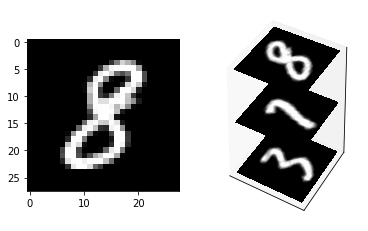

Sample: 110 - Class: [0] - Label Vector: 8 
Sample: 111 - Class: [0] - Label Vector: 7 
Sample: 112 - Class: [0] - Label Vector: 3 


In [59]:
samplesIdx = [110, 111, 112]  

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

ax1 = fig.add_subplot(121)
ax1.imshow(test_images[samplesIdx[0]].reshape([28,28]), cmap='gray')


xx, yy = np.meshgrid(np.linspace(0,28,28), np.linspace(0,28,28))
X =  xx ; Y =  yy
Z =  100*np.ones(X.shape)

img = test_images[77].reshape([28,28])
ax = fig.add_subplot(122, projection='3d')
ax.set_zlim((0,200))


offset=200
for i in samplesIdx:
    img = test_images[i].reshape([28,28]).transpose()
    ax.contourf(X, Y, img, 200, zdir='z', offset=offset, cmap="gray")
    offset -= 100

    ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

plt.show()


for i in samplesIdx:
    print ("Sample: {0} - Class: {1} - Label Vector: {2} ".format(i, np.nonzero(test_labels[i])[0], test_labels[i]))


**RNN**

Creating a recurrent Nueral Network

In [53]:
n_input = 28 # MNIST data input (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 
#hidden LSTM units
n_classes = 10 


learning_rate = 0.001
#mnist is meant to be classified in 10 classes(0-9).
training_iters = 100000
batch_size = 100
#size of batch
display_step = 10
x = tf.placeholder(dtype="float", shape=[None, n_steps, n_input], name="x") # Current data input shape: (batch_size, n_steps, n_input) [100x28x28]
y = tf.placeholder(dtype="float", shape=[None, n_classes], name="y")

Creating the weights and bias of the variables.

In [54]:
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

Now that we are receiving inputs of shape  [batch_size,time_steps,n_input] ,we need to convert it into a list of tensors of shape  [batch_size,n_inputs]  of length n_steps so that it can be then fed to static_rnn

In [62]:
input=tf.unstack(x ,n_steps,1)

In [65]:
x

<tf.Tensor 'x:0' shape=(?, 28, 28) dtype=float32>

Defining the Network

In [78]:
#lstm_layer=tf.compat.v1.nn.rnn_cell.BasicLSTMCell(n_hidden,forget_bias=1)
#outputs,_=tf.compat.v1.nn.rnn.static_rnn(lstm_layer,input,dtype="float32")
lstm_cell = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)

Now going to define our network.BY using the layers of BasicLSTMCell and make static_rnn network.

In [79]:
outputs, states = tf.nn.dynamic_rnn(lstm_cell, inputs=x, dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [82]:
outputs.shape

TensorShape([Dimension(None), Dimension(28), Dimension(128)])

Reshape

In [84]:
output = tf.reshape(tf.split(outputs, 28, axis=1, num=None, name='split')[-1],[-1,128])


RNN ---->
matmul is matrix multipliation 

In [88]:
prediction = tf.matmul(output, weights['out']) + biases['out']

In [89]:
#lets see the prediction
prediction

<tf.Tensor 'add_1:0' shape=(?, 10) dtype=float32>

In [90]:
#loss_function
loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction,labels=y))
#optimization
opt=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

#model evaluation
correct_prediction=tf.equal(tf.argmax(prediction,1),tf.argmax(y,1))
accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



We will form a session to see the model 

In [ ]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    step = 1
    # while loop to train all 
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
    
        # Run optimization 
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        
        if step % display_step == 0:
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step =step+ 1
    print("Optimization Finished!")

    # Calculate accuracy for 128 mnist test images
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_images, y: test_labels}))